#Run Every Session

##Import statements

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import copy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import shapiro
from sklearn.preprocessing import PowerTransformer

##Connecting Drive to Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Imputation and vector homogenization Utility Functions

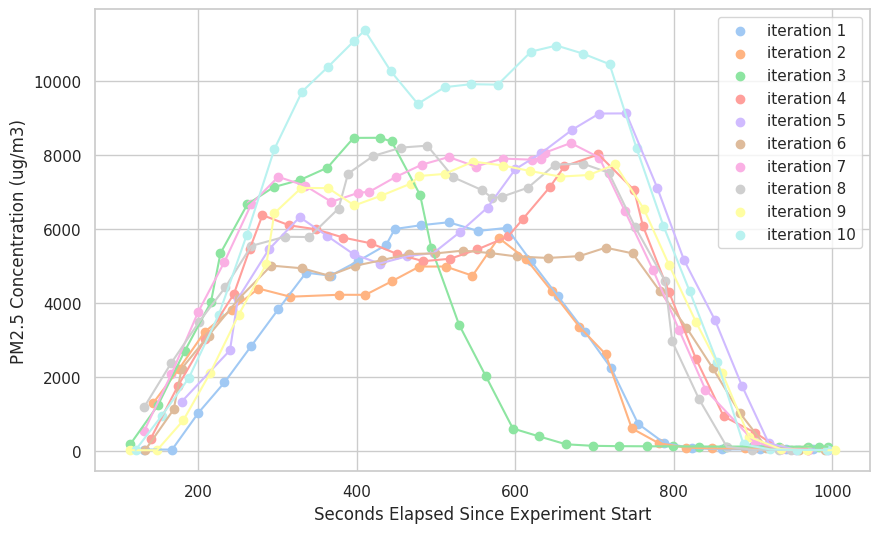

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Validation Box Dataset/Processed/Agarbatti/Agarbatti_Moving_Average_Filtered.csv")
plt.figure(figsize=(10,6))
for slno in df["iteration no."].unique():
  plt.scatter(df[df["iteration no."]==slno]["seconds_elapsed"],df[df["iteration no."]==slno]["pm2_5"], label = f"iteration {int(slno)}")
  plt.plot(df[df["iteration no."]==slno]["seconds_elapsed"],df[df["iteration no."]==slno]["pm2_5"])
plt.xlabel("Seconds Elapsed Since Experiment Start")
plt.ylabel("PM2.5 Concentration (ug/m3)")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import copy

def visualize_preprocessing_pipeline(df, flexibility=2):
    """Visualize preprocessing pipeline with consistent axes and transformations"""
    plt.rcParams.update({'font.size': 10, 'mathtext.fontset': 'stix'})
    fig = plt.figure(figsize=(14, 25), dpi=300)
    gs = GridSpec(4, 2, figure=fig, height_ratios=[1.2,1,1,1], hspace=0.6, wspace=0.3)

    # Shared axis limits
    time_axis = [df['seconds_elapsed'].min()-1, df['seconds_elapsed'].max()+1]
    pm_axis = [df['pm2_5'].min()-5, df['pm2_5'].max()+5]

    # Phase 1: Raw Input
    ax1 = fig.add_subplot(gs[0, :])
    for i in df["iteration no."].unique():
        subset = df[df["iteration no."] == i]
        ax1.plot(subset["seconds_elapsed"], subset["pm2_5"],
                'o-', markersize=8, alpha=0.7, label=f'Iter {i}')
    ax1.set_title("1. Raw Temporal Signatures", weight='bold', pad=15)
    ax1.set_xlabel("Time (seconds)", fontsize=11)
    ax1.set_ylabel("PM2.5 (µg/m³)", fontsize=11)
    ax1.set_xlim(time_axis)
    ax1.set_ylim(pm_axis)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.text(0.5, -0.15, r"$\mathcal{T}_i = \{t_{i1}, t_{i2}, \dots, t_{in_i}\}$",
            ha='center', transform=ax1.transAxes, fontsize=12)

    # Timestamp Homogenization
    original_matrix = [df[df["iteration no."]==i]["seconds_elapsed"].values
                     for i in df["iteration no."].unique()]
    pm_matrix = [df[df["iteration no."]==i]["pm2_5"].values
               for i in df["iteration no."].unique()]

    # Homogenization process
    aligned_time = []
    aligned_pm = []
    max_len = max(map(len, original_matrix))
    for t_vals, p_vals in zip(original_matrix, pm_matrix):
        new_t = np.full(max_len, np.nan)
        new_p = np.full(max_len, np.nan)
        new_t[:len(t_vals)] = t_vals
        new_p[:len(p_vals)] = p_vals
        aligned_time.append(new_t)
        aligned_pm.append(new_p)

    # Phase 2: Aligned Timestamps
    ax2 = fig.add_subplot(gs[1, 0])
    for i, (t_row, p_row) in enumerate(zip(aligned_time, aligned_pm)):
        valid = ~np.isnan(t_row)
        ax2.plot(t_row[valid], p_row[valid], 'o-', markersize=8, alpha=0.7)
        ax2.plot(t_row[~valid], np.zeros(sum(~valid)), 'o', markersize=10,
                markeredgewidth=1.5, markerfacecolor='none', color='red')
    ax2.set_title("2. Time-Aligned Signatures", weight='bold')
    ax2.set_xlabel("Time (seconds)", fontsize=11)
    ax2.set_ylabel("PM2.5 (µg/m³)", fontsize=11)
    ax2.set_xlim(time_axis)
    ax2.set_ylim(pm_axis)
    ax2.grid(True, alpha=0.3)
    ax2.text(0.5, -0.2, r"$[l_j, u_j] = \mu_j \pm 2\sigma_j$",
            ha='center', transform=ax2.transAxes, fontsize=12)

    # Phase 3: Serial Index Projection
    ax3 = fig.add_subplot(gs[1, 1])
    serial_indices = np.arange(max_len)
    for i, p_row in enumerate(aligned_pm):
        valid = ~np.isnan(p_row)
        ax3.plot(serial_indices[valid], p_row[valid], 'o-', markersize=8, alpha=0.7)
        ax3.plot(serial_indices[~valid], np.zeros(sum(~valid)), 'o', markersize=10,
                markeredgewidth=1.5, markerfacecolor='none', color='red')
    ax3.set_title("3. Serial Index Mapping", weight='bold')
    ax3.set_xlabel("Serial Index", fontsize=11)
    ax3.set_ylabel("PM2.5 (µg/m³)", fontsize=11)
    ax3.set_ylim(pm_axis)
    ax3.grid(True, alpha=0.3)
    ax3.text(0.5, -0.2, r"$s_j = \text{position}(t_{ij} \in [l_j, u_j])$",
            ha='center', transform=ax3.transAxes, fontsize=12)

    # Phase 4: Imputation Process
    ax4 = fig.add_subplot(gs[2, :])
    model = RandomForestRegressor()
    for i, p_row in enumerate(aligned_pm):
        valid = ~np.isnan(p_row)
        if sum(valid) > 1:
            model.fit(serial_indices[valid].reshape(-1,1), p_row[valid])
            p_imputed = model.predict(serial_indices.reshape(-1,1))
            ax4.plot(serial_indices, p_imputed, 'o-', markersize=8, alpha=0.7)
    ax4.set_title("4. Temporal Pattern Imputation", weight='bold')
    ax4.set_xlabel("Serial Index", fontsize=11)
    ax4.set_ylabel("PM2.5 (µg/m³)", fontsize=11)
    ax4.grid(True, alpha=0.3)
    ax4.text(0.5, -0.1, r"$\hat{x}_{ij} = \mathcal{R}(s_j|\{x_{ik}\}_{k \neq j})$",
            ha='center', transform=ax4.transAxes, fontsize=12)

    # Phase 5: Final Uniform Vectors
    ax5 = fig.add_subplot(gs[3, :])
    for i, p_row in enumerate(aligned_pm):
        valid = ~np.isnan(p_row)
        ax5.plot(serial_indices, p_row, 'o-', markersize=8, alpha=0.7)
    ax5.set_title("5. Final Uniform Vectors", weight='bold')
    ax5.set_xlabel("Serial Index", fontsize=11)
    ax5.set_ylabel("PM2.5 (µg/m³)", fontsize=11)
    ax5.grid(True, alpha=0.3)
    ax5.text(0.5, -0.1, r"$\mathbf{x}_i \in \mathbb{R}^d$ (Fixed-length representation)",
            ha='center', transform=ax5.transAxes, fontsize=12)

    plt.savefig('preprocessing_pipeline.pdf', bbox_inches='tight', dpi=300)
    plt.close()
    print("Visualization saved to preprocessing_pipeline.pdf")

# Example usage
visualize_preprocessing_pipeline(pd.read_csv("/content/drive/MyDrive/Validation Box Dataset/Processed/Agarbatti/Agarbatti_Moving_Average_Filtered.csv"))

Visualization saved to preprocessing_pipeline.pdf


In [ ]:
'''
In our time series data, we will make a vector with k number of datapoints.
So in order to assign a serial number to a variety of timestamps, we need to assign some limits.
We will also identify missing data, if any so as to impute it.
'''

def rearrange_rows(df, flexibility=2):
  original_matrix = [df[df["iteration no."]==i]["seconds_elapsed"].values.tolist() for i in df["iteration no."].unique()]
  original_matrix_copy = copy.deepcopy(original_matrix)
  rearranged_time_matrix = [[0]*len(a) for a in original_matrix]
  for i in range(max([len(a) for a in original_matrix])):
    col_data = [a[i] for a in original_matrix if len(a)>=i+1]
    upper_allowed_range = np.mean(col_data) + flexibility*np.std(col_data)
    lower_allowed_range = np.mean(col_data) - flexibility*np.std(col_data)

    for j in range(len(original_matrix)):
      row = original_matrix[j]
      if i<len(row):
        #Within range
        if row[i]<lower_allowed_range:
          #That means an outlier is there which is smaller than the other values in column
          #It is either missing data or a relevant data is to the right. But, this data cannot be shifted right
          #So it is safe to mark current data as nan
          row[i] = np.nan
          #Check the values on the right
          for k in range(i+1,len(row)):
            if row[k]>upper_allowed_range:
              break
            elif row[k]>=lower_allowed_range and row[k]<=upper_allowed_range:
              row[i] = row[k]
              #Since I used this timestamp up, so it will be nan now
              row[k] = np.nan
        rearranged_time_matrix[j] = row
  #nan padding the rearranged matrix
  max_cols = max([len(a) for a in rearranged_time_matrix])
  rearranged_time_matrix_padded = []
  for row in rearranged_time_matrix:
    row = row + [np.nan]*(max_cols-len(row))
    rearranged_time_matrix_padded.append(row)
  #I don't need datapoint serial nos that are mostly empty
  transposed_mtx = np.array(rearranged_time_matrix_padded).transpose()
  transposed_mtx_2 = []
  for row in transposed_mtx:
    if np.count_nonzero(~np.isnan(row))>=int(len(row)/2):
      transposed_mtx_2.append(row)
  rearranged_time_matrix_padded = np.array(transposed_mtx_2).transpose().tolist()
  return(original_matrix_copy,rearranged_time_matrix_padded)

In [ ]:
def add_datapoint_serial_number_and_mark_missing_data(df, rearranged_padded_seconds_elapsed_matrix, remove_before=False, remove_after=False, remove_during=False):
  def assign_datapoint_serial_number(x,rearranged_padded_seconds_elapsed_matrix):
    row = rearranged_padded_seconds_elapsed_matrix[int(x["iteration no."]-1)]
    if x["seconds_elapsed"] in row:
      return row.index(x["seconds_elapsed"])
    else:
      return np.nan

  og,new = rearrange_rows(df)
  df["datapoint_serial"] = df.apply(lambda x: assign_datapoint_serial_number(x, new), axis=1)
  if remove_before:
    df = df[df["phase"]!="before"]
  if remove_after:
    df = df[df["phase"]!="after"]
  if remove_during:
    df = df[df["phase"]!="during"]
  df2 = df.drop(["Unnamed: 0", "timestamp", "phase"], axis=1).dropna()

  comfort_factors = ['pm1', 'co', 'humidity', 'co2', 'pm2_5', 'pm10', 'temperature', 'voc']
  missing_rows_df = {}
  for col in df2.columns:
    if col not in list(missing_rows_df.keys()):
      missing_rows_df[col] = []

  device_id = df2.iloc[0]["device_id"]
  for i in df2["iteration no."].unique():
    for a in [serial_no for serial_no in df2["datapoint_serial"].unique() if serial_no not in df2[df2["iteration no."]==i]["datapoint_serial"].unique()]:
      for factor in comfort_factors:
        missing_rows_df[factor].append(np.nan)
      missing_rows_df["device_id"].append(device_id)
      missing_rows_df["iteration no."].append(i)
      missing_rows_df["seconds_elapsed"].append(np.nan)
      missing_rows_df["datapoint_serial"].append(a)
  print(missing_rows_df)
  df_with_missing_data = pd.concat([df2,pd.DataFrame(missing_rows_df)]).sort_values(by=["iteration no.","datapoint_serial"])
  return df_with_missing_data

In [ ]:
def perform_imputation(df_with_missing_data):
  def scale_df(x, col, scaler_lookup):
    scaler = scaler_lookup[x["iteration no."]][col]
    return scaler.transform([[x[col]]]).flatten()[0]

  def impute_and_unscale(x, col, scaler_lookup, regressor_lookup):
    if np.isnan(x[col]):
      return scaler_lookup[x["iteration no."]][col].inverse_transform([regressor_lookup[col].predict([[x["datapoint_serial"]]])]).flatten()[0]
    else:
      return scaler_lookup[x["iteration no."]][col].inverse_transform([[x[col]]]).flatten()[0]

  scaler_lookup = {}
  regressor_lookup = {}
  for i in df_with_missing_data["iteration no."].unique():
    for col in df_with_missing_data.columns:
      scaler = MinMaxScaler()
      if i not in list(scaler_lookup.keys()):
        scaler_lookup[i] = {}
      scaler_lookup[i][col] = scaler.fit(df_with_missing_data[df_with_missing_data["iteration no."]==i][col].values.reshape(-1,1))

  df_scaled = pd.DataFrame()
  for col in df_with_missing_data.columns:
    if col == "datapoint_serial":
      df_scaled[col] = df_with_missing_data[col]
    elif col != "iteration no.":
      df_scaled[col] = df_with_missing_data[[col, "iteration no."]].apply(lambda x:scale_df(x,col,scaler_lookup),axis=1)
    else:
      df_scaled[col] = df_with_missing_data["iteration no."]

  for col in df_scaled.columns:
    if col not in ["datapoint_serial", "iteration no."]:
      X_train = df_scaled[[col,"datapoint_serial"]].dropna()["datapoint_serial"]
      y_train = df_scaled[[col,"datapoint_serial"]].dropna()[col]
      X_test = df_scaled[df_scaled[[col,"datapoint_serial"]].isnull().any(axis=1)]["datapoint_serial"]
      y_test = df_scaled[df_scaled[[col,"datapoint_serial"]].isnull().any(axis=1)][col]
      #regressor_lookup[col] = SVR(kernel="rbf").fit(X_train.values.reshape(-1, 1), y_train.values)
      regressor_lookup[col] = RandomForestRegressor().fit(X_train.values.reshape(-1, 1), y_train.values)

  df_imputed = pd.DataFrame()
  for col in df_scaled.columns:
    if col == "datapoint_serial":
      df_imputed[col] = df_scaled[col]
    elif col != "iteration no.":
      df_imputed[col] = df_scaled[[col, "iteration no.", "datapoint_serial"]].apply(lambda x:impute_and_unscale(x,col,scaler_lookup, regressor_lookup),axis=1)
    else:
      df_imputed[col] = df_scaled["iteration no."]

  return df_imputed

In [ ]:
def impute_data(df_path):
  return perform_imputation(add_datapoint_serial_number_and_mark_missing_data(pd.read_csv(df_path), rearrange_rows(pd.read_csv(df_path))[1]))

#Imputation tool

In [ ]:
activities = ["incense stick", "cigarette"]
filters = ["raw","moving average","savitzky golay"]
files = {
    "incense stick": {
        "raw": "/content/drive/MyDrive/Validation Box Dataset/Raw/Agarbatti/Agg_Raw_Data.csv",
        "moving average": "/content/drive/MyDrive/Validation Box Dataset/Processed/Agarbatti/Agarbatti_Moving_Average_Filtered.csv",
        "savitzky golay": "/content/drive/MyDrive/Validation Box Dataset/Processed/Agarbatti/Agarbatti_Savitzky_Golay_Filtered.csv"
    },
    "cigarette": {
        "raw": "/content/drive/MyDrive/Validation Box Dataset/Raw/Cigarette/Cigg_Raw.Data.csv",
        "moving average": "/content/drive/MyDrive/Validation Box Dataset/Processed/Cigarette/Cigg_Processed_Moving_Average.csv",
        "savitzky golay": "/content/drive/MyDrive/Validation Box Dataset/Processed/Cigarette/Cigg_Processed_Savitzky_Golay.csv"
    },

}
vectors = {
    "incense stick": {
        "raw": impute_data(files["incense stick"]["raw"]),
        "moving average": impute_data(files["incense stick"]["moving average"]),
        "savitzky golay": impute_data(files["incense stick"]["savitzky golay"])
    },
    "cigarette": {
        "raw": impute_data(files["cigarette"]["raw"]),
        "moving average": impute_data(files["cigarette"]["moving average"]),
        "savitzky golay": impute_data(files["cigarette"]["savitzky golay"])
    },
}

{'pm1': [nan, nan, nan, nan, nan, nan], 'device_id': [np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0)], 'co': [nan, nan, nan, nan, nan, nan], 'humidity': [nan, nan, nan, nan, nan, nan], 'co2': [nan, nan, nan, nan, nan, nan], 'pm2_5': [nan, nan, nan, nan, nan, nan], 'pm10': [nan, nan, nan, nan, nan, nan], 'temperature': [nan, nan, nan, nan, nan, nan], 'voc': [nan, nan, nan, nan, nan, nan], 'iteration no.': [np.float64(2.0), np.float64(2.0), np.float64(5.0), np.float64(5.0), np.float64(5.0), np.float64(6.0)], 'seconds_elapsed': [nan, nan, nan, nan, nan, nan], 'datapoint_serial': [np.float64(29.0), np.float64(30.0), np.float64(28.0), np.float64(29.0), np.float64(30.0), np.float64(30.0)]}
{'pm1': [nan, nan, nan, nan, nan, nan], 'device_id': [np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0)], 'co': [nan, nan, nan, nan, nan, nan], 'humidity': [nan, nan, nan, nan, nan, nan], 'co2': [nan, n

#Gaussian Test
Is the input vector Gaussian?

In [ ]:
pm2_5_vector = vectors['cigarette']['moving average'][["datapoint_serial","pm2_5"]]

Shapiro Test of Each Iteration

In [ ]:
print([float(shapiro(pm2_5_vector[pm2_5_vector["datapoint_serial"]==slno]["pm2_5"]).pvalue) for slno in pm2_5_vector["datapoint_serial"].unique()])

[0.03165552209148419, 0.8172876805336189, 0.7497714370588171, 0.8789584648069476, 0.38367729274487467, 0.5661005840454689, 0.3486829568402975, 0.728964440373803, 0.6314758289206439, 0.45325441894463003, 0.7062878528281199, 0.6799921718888396, 0.9562134849061578, 0.761833267477146, 0.8277747681523413, 0.34277216364690466, 0.947146189035123, 0.6398362758977549, 0.03758560105875725, 0.010717104143426184, 0.0255453242994049, 6.793414680333533e-05, 1.5857366805171405e-05, 0.0003963604145184018, 0.22627967738260552, 0.21961271543646577]


/tmp/ipython-input-2948612931.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([unfiltered, moving_average, savitzky_golay], labels=['Unfiltered', 'Moving Average', 'Savitzky-Golay'])
/tmp/ipython-input-2948612931.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([unfiltered, moving_average, savitzky_golay], labels=['Unfiltered', 'Moving Average', 'Savitzky-Golay'])


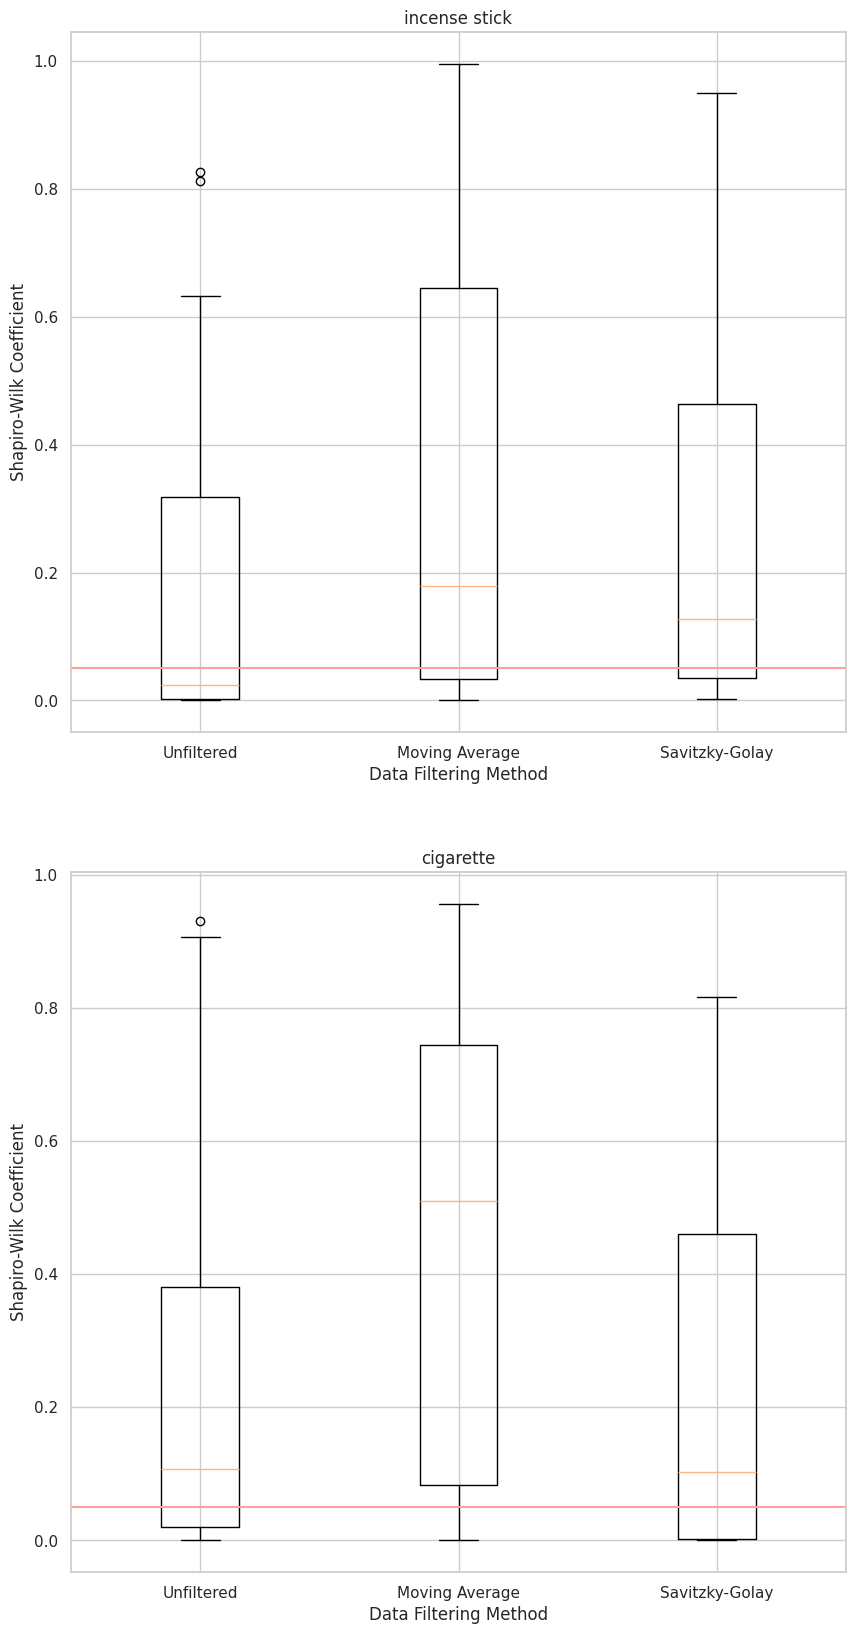

In [ ]:
plt.figure(figsize=(10,20))
#for i in range(len(list(vectors.keys()))):
for i in range(2):
  plt.subplot(2,1,i+1)
  pm2_5_vector = vectors[list(vectors.keys())[i]]['raw'][["datapoint_serial","pm2_5"]]
  unfiltered = [float(shapiro(pm2_5_vector[pm2_5_vector["datapoint_serial"]==slno]["pm2_5"]).pvalue) for slno in pm2_5_vector["datapoint_serial"].unique()]
  pm2_5_vector = vectors[list(vectors.keys())[i]]['moving average'][["datapoint_serial","pm2_5"]]
  moving_average = [float(shapiro(pm2_5_vector[pm2_5_vector["datapoint_serial"]==slno]["pm2_5"]).pvalue) for slno in pm2_5_vector["datapoint_serial"].unique()]
  pm2_5_vector = vectors[list(vectors.keys())[i]]['savitzky golay'][["datapoint_serial","pm2_5"]]
  savitzky_golay = [float(shapiro(pm2_5_vector[pm2_5_vector["datapoint_serial"]==slno]["pm2_5"]).pvalue) for slno in pm2_5_vector["datapoint_serial"].unique()]
  plt.boxplot([unfiltered, moving_average, savitzky_golay], labels=['Unfiltered', 'Moving Average', 'Savitzky-Golay'])
  plt.axhline(y=0.05, color='r', linestyle='-')
  plt.title(list(vectors.keys())[i])
  plt.xlabel('Data Filtering Method')
  plt.ylabel('Shapiro-Wilk Coefficient')
plt.savefig("Shapiro-Wilk_Test_Coefficients.pdf",bbox_inches="tight")

##Filtered Data is Gaussian in Nature

In [ ]:
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [ ]:
# new_vector = pd.concat([
#         vectors["incense stick"]["moving average"][["datapoint_serial","pm2_5"]],
#         vectors["cigarette"]["moving average"][["datapoint_serial","pm2_5"]],
#     ], ignore_index=True)
pm2_5_vector = vectors["cigarette"]["moving average"]
#pm2_5_vector = new_vector
x = []
for slno in pm2_5_vector["datapoint_serial"].unique():
  x.append(pm2_5_vector[pm2_5_vector["datapoint_serial"]==slno]["pm2_5"].values)
means = [np.mean(a) for a in x]
std_devs = [np.std(a) for a in x]

In [ ]:
agarbatti_vector = vectors["incense stick"]["raw"][["datapoint_serial","pm2_5"]]
x_agarbatti = []
for slno in agarbatti_vector["datapoint_serial"].unique():
  x_agarbatti.append(agarbatti_vector[agarbatti_vector["datapoint_serial"]==slno]["pm2_5"].values)
datapoints = min(len(means),len(x_agarbatti))
num_iters = min(len(x[0]),len(x_agarbatti[0]))
agarbatti = []
epsilon = 1e-300  # To avoid log10(0), very small positive number

for iter in range(num_iters):
    probability = 1.0
    for datapoint in range(datapoints):
        prob = normpdf(x_agarbatti[datapoint][iter], means[datapoint], std_devs[datapoint])
        probability *= prob
    agarbatti.append(float(np.abs(np.log10(max(probability, epsilon)))))

In [ ]:
cigarette_vector = vectors["cigarette"]["raw"][["datapoint_serial","pm2_5"]]
x_cigarette = []
for slno in cigarette_vector["datapoint_serial"].unique():
  x_cigarette.append(cigarette_vector[cigarette_vector["datapoint_serial"]==slno]["pm2_5"].values)
datapoints = min(len(means),len(x_cigarette))
num_iters = min(len(x[0]),len(x_cigarette[0]))
cigarette = []
epsilon = 1e-300  # To avoid log10(0), very small positive number
for iter in range(num_iters):
  probability = 1
  for datapoint in range(datapoints):
    probability = probability*normpdf(x_cigarette[datapoint][iter],means[datapoint],std_devs[datapoint])
  cigarette.append(float(np.abs(np.log10(max(probability, epsilon)))))

In [ ]:
faulty_df = pd.read_csv("/content/drive/MyDrive/Validation Box Dataset/Raw/Raw_Fault_vs_Working_Annot_Final.csv")
faulty_df = faulty_df[faulty_df["iteration no."]>5]
faulty_df["iteration no."] = (faulty_df["iteration no."] - 5)
faulty_df[['pm1', 'device_id', 'co', 'humidity', 'co2', 'pm2_5',
       'pm10', 'temperature', 'voc', 'timestamp', 'iteration no.', 'phase',
       'seconds_elapsed']].to_csv("temp.csv")
faulty_vector = impute_data("temp.csv")

{'pm1': [nan, nan, nan, nan, nan, nan], 'device_id': [np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0)], 'co': [nan, nan, nan, nan, nan, nan], 'humidity': [nan, nan, nan, nan, nan, nan], 'co2': [nan, nan, nan, nan, nan, nan], 'pm2_5': [nan, nan, nan, nan, nan, nan], 'pm10': [nan, nan, nan, nan, nan, nan], 'temperature': [nan, nan, nan, nan, nan, nan], 'voc': [nan, nan, nan, nan, nan, nan], 'iteration no.': [np.float64(2.0), np.float64(5.0), np.float64(5.0), np.float64(5.0), np.float64(5.0), np.float64(5.0)], 'seconds_elapsed': [nan, nan, nan, nan, nan, nan], 'datapoint_serial': [np.float64(29.0), np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0)]}


In [ ]:
x_faulty = []
for slno in faulty_vector["datapoint_serial"].unique():
  x_faulty.append(faulty_vector[faulty_vector["datapoint_serial"]==slno]["pm2_5"].values)
datapoints = min(len(means),len(x_faulty))
num_iters = min(len(x[0]),len(x_faulty[0]))
faulty = []
epsilon = 1e-300
for iter in range(num_iters):
  probability = 1
  for datapoint in range(datapoints):
    probability = probability*normpdf(x_faulty[datapoint][iter],means[datapoint],std_devs[datapoint])
  faulty.append(float(np.abs(np.log10(max(probability, epsilon)))))

/tmp/ipython-input-422491120.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cigarette, faulty], labels=['Working Sensor', 'Faulty Sensor (Obstructed Airflow)'])


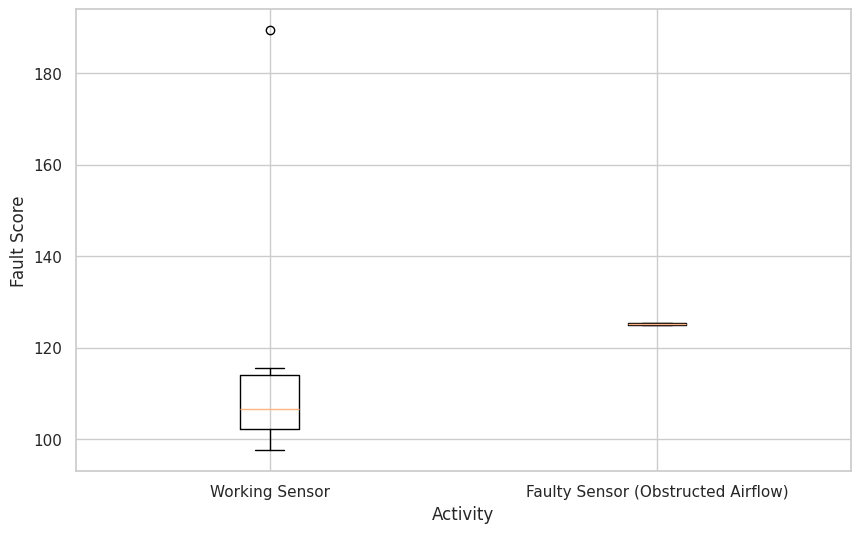

In [ ]:
plt.figure(figsize=(10,6))
plt.boxplot([cigarette, faulty], labels=['Working Sensor', 'Faulty Sensor (Obstructed Airflow)'])
plt.xlabel('Activity')
plt.ylabel('Fault Score')
plt.savefig('inter-activity_fault_scores_working_vs_faulty.pdf',bbox_inches='tight')

In [ ]:
cigarette

[189.3427259027593,
 111.25567630371879,
 106.67644299849243,
 106.32365776076135,
 102.14495876026882,
 97.54432700838757,
 114.87997393381558,
 102.01608454869594,
 102.55131580295684,
 115.62621695336234]

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Validation Box Dataset/Raw/Raw_Fault_vs_Working_Annot_Final.csv")

In [ ]:
faulty_df[["iteration no.","pm2_5"]].groupby("iteration no.").mean()["pm2_5"]

,pm2_5
iteration no.,
1.0,21.032258
2.0,28.827586
3.0,37.266667
4.0,4.133333
5.0,7.360000


In [ ]:
mean_cigarette = np.mean(cigarette)
mean_faulty = np.mean(faulty)
std_cigarette = np.std(cigarette)
std_faulty = np.std(faulty)

In [ ]:
print(mean_cigarette, mean_faulty, std_cigarette, std_faulty)

114.83613799732188 125.16968794758623 25.454005225749288 0.1921218670032443


In [ ]:
datapoints = len(means)
num_iters = len(x[0])
a = []
for iter in range(num_iters):
  probability = 1
  for datapoint in range(datapoints):
    normpdf(x[datapoint][iter],means[datapoint],std_devs[datapoint])
    probability = probability*normpdf(x[datapoint][iter],means[datapoint],std_devs[datapoint])
  a.append(float(np.abs(np.log10(probability))))
print(a)

[103.97725597032404, 95.17602151915956, 93.48740457931613, 94.27012012885324, 98.52680536219552, 97.99219769264103, 96.28407938295021, 96.03348240119125, 95.83021731523856, 96.511003190458]


In [ ]:
len(means)

26

Agarbatti Burning -> Same, higher probability

Cigarette Burning -> Closer, higher probability

Deodorant Spraying -> Farther, lower probability

#Relevant Graphs

##Shapiro Result Boxplot

/tmp/ipython-input-115615601.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([unfiltered, moving_average, savitzky_golay], labels=['Unfiltered', 'Moving Average', 'Savitzky-Golay'])


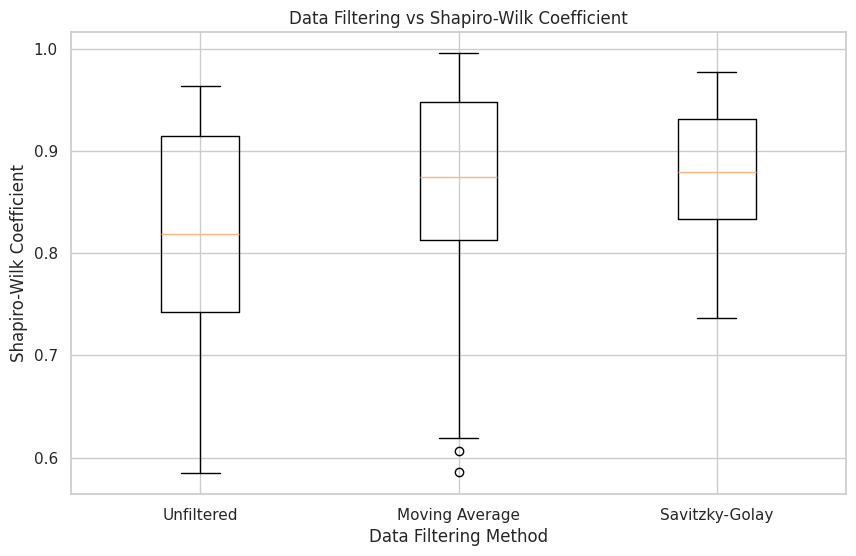

In [ ]:
unfiltered = [0.7689333360605847, 0.7360398716545851, 0.7314911918420615, 0.584588203196232, 0.7946955474783265, 0.8191557063271562, 0.9459135110123437, 0.9469678069958594, 0.9636944576788304, 0.8263436373978984, 0.7527236299733964, 0.916827061442086, 0.9136032651506696, 0.8724810920278885, 0.9304953836537475, 0.9241563886294349, 0.935342781598827, 0.9623754113332097, 0.8852404807491415, 0.8932318716394606, 0.779688964060027, 0.7960088815336827, 0.8385998000490255, 0.7489240327098324, 0.7323231970078035, 0.9128191156333554, 0.7723203664772267, 0.7002452442707332, 0.7026889043171977, 0.7152711247243326, 0.6979269374291946]
moving_average = [0.9957932008869251, 0.830548864984614, 0.8449118472616342, 0.7685188128738584, 0.9679838707920606, 0.9039585142440189, 0.7707041515838727, 0.9253010885863535, 0.9614931155882847, 0.9681956675187755, 0.8838975668938716, 0.8362785415231391, 0.8376426436850526, 0.9025375321323772, 0.9619378777830259, 0.852468128773818, 0.9580468311315191, 0.9768517670714857, 0.8749064590834603, 0.8673532427317727, 0.7947596164768033, 0.703048462727399, 0.6068265197882753, 0.5856257927730641, 0.6194189169512697, 0.6819245178855005, 0.8744206863258175, 0.881766378096665, 0.9579260138085619, 0.9332594670555655, 0.9379919906300964]
savitzky_golay = [0.9692783426503817, 0.8285489162300159, 0.8216731772950965, 0.7905922718277083, 0.9340391800125571, 0.9273809104588884, 0.9332749826410109, 0.977484044517744, 0.9235710436938012, 0.8220703491933702, 0.8632201263997105, 0.9009882830174458, 0.8808748258158616, 0.9393612666845281, 0.9449700504320553, 0.8848252411026913, 0.9604998805430737, 0.9566559601592924, 0.9182853344746089, 0.8775324698654499, 0.8076153334831145, 0.8633921782091177, 0.7742775738063363, 0.8524542350495794, 0.8791608746650256, 0.8654197159390786, 0.9299817445347958, 0.7369363204727241, 0.8189186067290599, 0.837616024365889, 0.8523356118771482]
plt.figure(figsize=(10,6))
plt.boxplot([unfiltered, moving_average, savitzky_golay], labels=['Unfiltered', 'Moving Average', 'Savitzky-Golay'])
plt.title('Data Filtering vs Shapiro-Wilk Coefficient')
plt.xlabel('Data Filtering Method')
plt.ylabel('Shapiro-Wilk Coefficient')
plt.show()

##Same vs Similar vs Different Activities

/tmp/ipython-input-2313084597.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([agarbatti, cigarette], labels=['Incense Stick', 'Cigarette'])


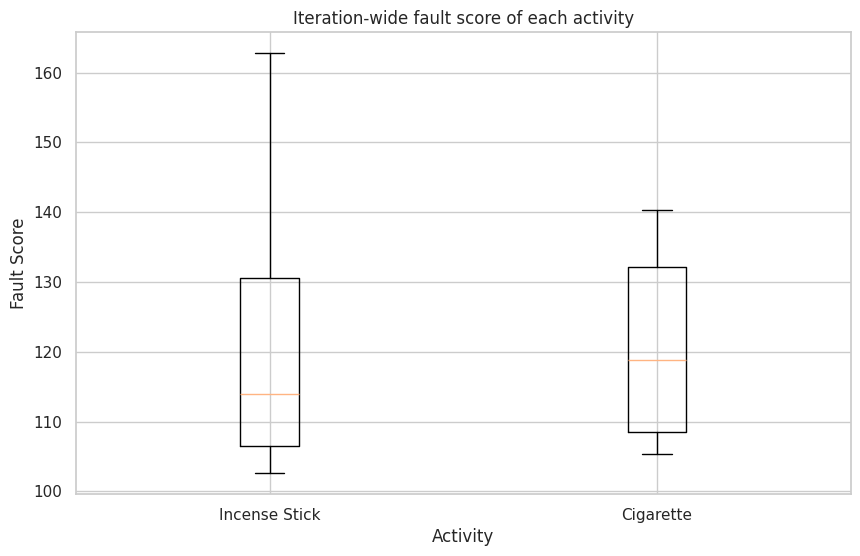

In [ ]:
agarbatti = [108.85926074797172, 104.20761233089166, 109.10274740261674, 152.3367364413719, 102.5937540600775, 105.68327415087525, 130.60095253113334, 118.71347268041772, 162.76214101919928, 130.25233929432022]
cigarette = [112.48081841285278, 117.21043827004195, 120.48445530515296, 135.31529840589184, 107.08247636126148, 105.39269771694896, 140.25260426933139, 122.51312509173749, 106.25382970666628, 138.37861198166127]
plt.figure(figsize=(10,6))
plt.boxplot([agarbatti, cigarette], labels=['Incense Stick', 'Cigarette'])
plt.title('Iteration-wide fault score of each activity')
plt.xlabel('Activity')
plt.ylabel('Fault Score')
plt.show()

##Fault Detection

In [ ]:
signature_in_row = np.array(x).transpose()

[np.float64(104.02803001976224), np.float64(95.21146943714018), np.float64(93.50671494250092), np.float64(94.25473670474454), np.float64(98.49661352223285), np.float64(97.99918755504241), np.float64(96.26186317654002), np.float64(96.04198307712532), np.float64(95.80934345670342), np.float64(96.48161346442157)]
[np.float64(109.92076863629013), np.float64(102.65646559611145), np.float64(94.78157482056784), np.float64(112.12057159027012), np.float64(99.72535512197327), np.float64(99.45437595408431), np.float64(106.44986334932638), np.float64(100.9322305592134), np.float64(96.07080744107331), np.float64(99.54738186578702)]
[np.float64(106.99077116315105), np.float64(142.83462049904068), np.float64(136.44960506866852), np.float64(101.10303967766623), np.float64(103.58624690893811), np.float64(106.03330030068472), np.float64(102.9187669346358), np.float64(176.95563768465368), np.float64(103.54613808632472), np.float64(105.73688361690304)]


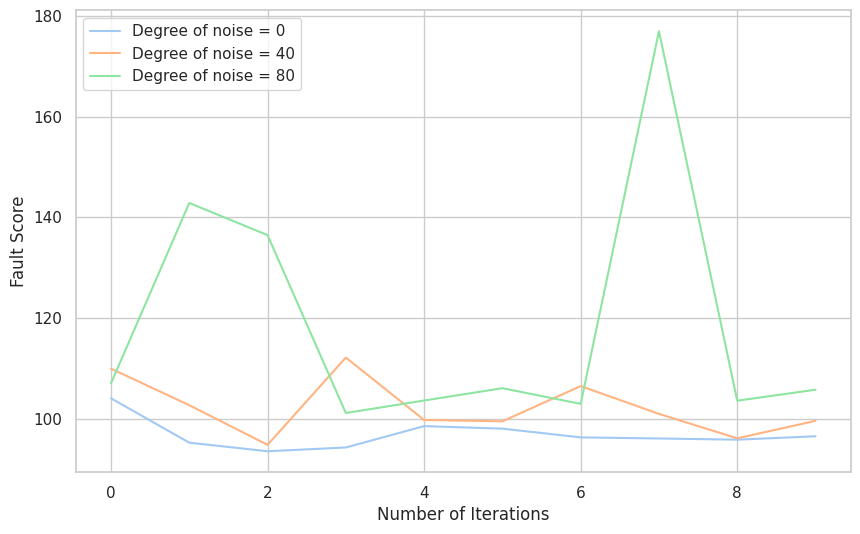

In [ ]:
plt.figure(figsize=(10,6))
for degree_of_noise in range(0,100,40):
  prob_arr = []
  for signature in signature_in_row:
    probability=1
    noise = np.random.normal(0, (degree_of_noise/100)*(np.std(signature)/10), len(signature))
    data = signature+noise
    for datapoint in range(len(means)):
      probability = probability*normpdf(data[datapoint]+1,means[datapoint],std_devs[datapoint])
    prob_arr.append(np.abs(np.log10(probability)))
  plt.plot(prob_arr,label="Degree of noise = "+str(degree_of_noise))
  plt.legend()
  plt.xlabel("Number of Iterations")
  plt.ylabel("Fault Score")
  print(prob_arr)
plt.savefig("Fault_score_vs_iteration_vs_degree_of_noise.pdf",bbox_inches="tight")

#Final

In [ ]:
# Run Every Session

## Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import copy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import shapiro
from sklearn.preprocessing import PowerTransformer
import seaborn as sns

# Connecting Drive to Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## Imputation and vector homogenization Utility Functions

'''
In our time series data, we will make a vector with k number of datapoints.
So in order to assign a serial number to a variety of timestamps, we need to assign some limits.
We will also identify missing data, if any so as to impute it.
'''

def rearrange_rows(df, flexibility=2):
    original_matrix = [df[df["iteration no."]==i]["seconds_elapsed"].values.tolist() for i in df["iteration no."].unique()]
    original_matrix_copy = copy.deepcopy(original_matrix)
    rearranged_time_matrix = [[0]*len(a) for a in original_matrix]
    for i in range(max([len(a) for a in original_matrix])):
        col_data = [a[i] for a in original_matrix if len(a)>=i+1]
        upper_allowed_range = np.mean(col_data) + flexibility*np.std(col_data)
        lower_allowed_range = np.mean(col_data) - flexibility*np.std(col_data)

        for j in range(len(original_matrix)):
            row = original_matrix[j]
            if i<len(row):
                # Within range
                if row[i]<lower_allowed_range:
                    row[i] = np.nan
                    for k in range(i+1,len(row)):
                        if row[k]>upper_allowed_range:
                            break
                        elif row[k]>=lower_allowed_range and row[k]<=upper_allowed_range:
                            row[i] = row[k]
                            row[k] = np.nan
        rearranged_time_matrix[j] = row

    max_cols = max([len(a) for a in rearranged_time_matrix])
    rearranged_time_matrix_padded = []
    for row in rearranged_time_matrix:
        row = row + [np.nan]*(max_cols-len(row))
        rearranged_time_matrix_padded.append(row)

    transposed_mtx = np.array(rearranged_time_matrix_padded).transpose()
    transposed_mtx_2 = []
    for row in transposed_mtx:
        if np.count_nonzero(~np.isnan(row))>=int(len(row)/2):
            transposed_mtx_2.append(row)
    rearranged_time_matrix_padded = np.array(transposed_mtx_2).transpose().tolist()
    return(original_matrix_copy, rearranged_time_matrix_padded)

def add_datapoint_serial_number_and_mark_missing_data(df, rearranged_padded_seconds_elapsed_matrix, remove_before=False, remove_after=False, remove_during=False):
    def assign_datapoint_serial_number(x, rearranged_padded_seconds_elapsed_matrix):
        row = rearranged_padded_seconds_elapsed_matrix[int(x["iteration no."]-1)]
        if x["seconds_elapsed"] in row:
            return row.index(x["seconds_elapsed"])
        else:
            return np.nan

    og, new = rearrange_rows(df)
    df["datapoint_serial"] = df.apply(lambda x: assign_datapoint_serial_number(x, new), axis=1)
    if remove_before:
        df = df[df["phase"]!="before"]
    if remove_after:
        df = df[df["phase"]!="after"]
    if remove_during:
        df = df[df["phase"]!="during"]
    df2 = df.drop(["Unnamed: 0", "timestamp", "phase"], axis=1).dropna()

    comfort_factors = ['pm1', 'co', 'humidity', 'co2', 'pm2_5', 'pm10', 'temperature', 'voc']
    missing_rows_df = {}
    for col in df2.columns:
        if col not in list(missing_rows_df.keys()):
            missing_rows_df[col] = []

    device_id = df2.iloc[0]["device_id"]
    for i in df2["iteration no."].unique():
        for a in [serial_no for serial_no in df2["datapoint_serial"].unique() if serial_no not in df2[df2["iteration no."]==i]["datapoint_serial"].unique()]:
            for factor in comfort_factors:
                missing_rows_df[factor].append(np.nan)
            missing_rows_df["device_id"].append(device_id)
            missing_rows_df["iteration no."].append(i)
            missing_rows_df["seconds_elapsed"].append(np.nan)
            missing_rows_df["datapoint_serial"].append(a)

    df_with_missing_data = pd.concat([df2, pd.DataFrame(missing_rows_df)]).sort_values(by=["iteration no.", "datapoint_serial"])
    return df_with_missing_data

def perform_imputation(df_with_missing_data):
    def scale_df(x, col, scaler_lookup):
        scaler = scaler_lookup[x["iteration no."]][col]
        return scaler.transform([[x[col]]]).flatten()[0]

    def impute_and_unscale(x, col, scaler_lookup, regressor_lookup):
        if np.isnan(x[col]):
            return scaler_lookup[x["iteration no."]][col].inverse_transform([regressor_lookup[col].predict([[x["datapoint_serial"]]])]).flatten()[0]
        else:
            return scaler_lookup[x["iteration no."]][col].inverse_transform([[x[col]]]).flatten()[0]

    scaler_lookup = {}
    regressor_lookup = {}
    for i in df_with_missing_data["iteration no."].unique():
        for col in df_with_missing_data.columns:
            scaler = MinMaxScaler()
            if i not in list(scaler_lookup.keys()):
                scaler_lookup[i] = {}
            scaler_lookup[i][col] = scaler.fit(df_with_missing_data[df_with_missing_data["iteration no."]==i][col].values.reshape(-1,1))

    df_scaled = pd.DataFrame()
    for col in df_with_missing_data.columns:
        if col == "datapoint_serial":
            df_scaled[col] = df_with_missing_data[col]
        elif col != "iteration no.":
            df_scaled[col] = df_with_missing_data[[col, "iteration no."]].apply(lambda x:scale_df(x,col,scaler_lookup),axis=1)
        else:
            df_scaled[col] = df_with_missing_data["iteration no."]

    for col in df_scaled.columns:
        if col not in ["datapoint_serial", "iteration no."]:
            X_train = df_scaled[[col,"datapoint_serial"]].dropna()["datapoint_serial"]
            y_train = df_scaled[[col,"datapoint_serial"]].dropna()[col]
            X_test = df_scaled[df_scaled[[col,"datapoint_serial"]].isnull().any(axis=1)]["datapoint_serial"]
            y_test = df_scaled[df_scaled[[col,"datapoint_serial"]].isnull().any(axis=1)][col]
            regressor_lookup[col] = RandomForestRegressor().fit(X_train.values.reshape(-1, 1), y_train.values)

    df_imputed = pd.DataFrame()
    for col in df_scaled.columns:
        if col == "datapoint_serial":
            df_imputed[col] = df_scaled[col]
        elif col != "iteration no.":
            df_imputed[col] = df_scaled[[col, "iteration no.", "datapoint_serial"]].apply(lambda x:impute_and_unscale(x,col,scaler_lookup, regressor_lookup),axis=1)
        else:
            df_imputed[col] = df_scaled["iteration no."]

    return df_imputed

def impute_data(df_path):
    return perform_imputation(add_datapoint_serial_number_and_mark_missing_data(pd.read_csv(df_path), rearrange_rows(pd.read_csv(df_path))[1]))


## New Data Visualization Functions

# Function to perform the Shapiro-Wilk test on each column and return p-values
def perform_shapiro_test(df):
    p_values = [float(shapiro(df[df["datapoint_serial"]==slno]["pm2_5"]).statistic) for slno in df["datapoint_serial"].unique()]
    return p_values

# Function to create the boxplot
def plot_shapiro_boxplot(df_raw, df_mov_avg, df_savgol):
    # Create a figure
    plt.figure(figsize=(12, 8))

    # Data for the boxplots
    data = [df_raw.values.flatten(), df_mov_avg.values.flatten(), df_savgol.values.flatten()]

    # Plot the boxplots
    plt.boxplot(data, vert=False)

    # Set x-axis labels
    plt.yticks([1, 2, 3], ['Raw', 'Moving Average', 'Savitzky-Golay'])

    # Add title and axis labels
    plt.xlabel('Shapiro-Wilk Test Statistic')

    # Display the plot
    plt.tight_layout()
    plt.savefig("shapiro.pdf")

# Fault Detection Graph (can be customized based on your exact conditions)
def plot_fault_detection(df):
    plt.figure(figsize=(10,6))
    plt.plot(df['time'], df['fault_score'], label='Fault Detection')
    plt.title('Fault Detection Over Time')
    plt.xlabel('Time')
    plt.ylabel('Fault Score')
    plt.legend()
    plt.show()

# Gaussian Distribution for Agarbatti, Cigarette, and Burning Activity
def plot_gaussian_distribution(df_agarbatti, df_cigarette, df_burning_activity):
    plt.figure(figsize=(10,6))

    sns.kdeplot(df_agarbatti['pm2_5'], label='Agarbatti', fill=True, alpha=0.3)
    sns.kdeplot(df_cigarette['pm2_5'], label='Cigarette', fill=True, alpha=0.3)
    sns.kdeplot(df_burning_activity['pm2_5'], label='Burning Activity', fill=True, alpha=0.3)

    plt.title('Gaussian Distributions: Agarbatti, Cigarette, and Burning Activity')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Fault Scores Difference Visualization (for similar vs same vs different activities)
def plot_fault_score_difference(df_similar, df_same, df_diff):
    plt.figure(figsize=(10,6))
    plt.plot(df_similar['time'], df_similar['fault_score'], label='Similar Activities', color='blue')
    plt.plot(df_same['time'], df_same['fault_score'], label='Same Activity', color='green')
    plt.plot(df_diff['time'], df_diff['fault_score'], label='Different Activity', color='red')
    plt.title('Fault Score Comparison: Similar, Same, and Different Activities')
    plt.xlabel('Time')
    plt.ylabel('Fault Score')
    plt.legend()
    plt.show()

Mounted at /content/drive


In [ ]:
activities = ["incense stick", "cigarette"]
filters = ["raw","moving average","savitzky golay"]
files = {
    "incense stick": {
        "raw": "/content/drive/MyDrive/Validation Box Dataset/Raw/Agarbatti/Agg_Raw_Data.csv",
        "moving average": "/content/drive/MyDrive/Validation Box Dataset/Processed/Agarbatti/Agarbatti_Moving_Average_Filtered.csv",
        "savitzky golay": "/content/drive/MyDrive/Validation Box Dataset/Processed/Agarbatti/Agarbatti_Savitzky_Golay_Filtered.csv"
    },
    "cigarette": {
        "raw": "/content/drive/MyDrive/Validation Box Dataset/Raw/Cigarette/Cigg_Raw.Data.csv",
        "moving average": "/content/drive/MyDrive/Validation Box Dataset/Processed/Cigarette/Cigg_Processed_Moving_Average.csv",
        "savitzky golay": "/content/drive/MyDrive/Validation Box Dataset/Processed/Cigarette/Cigg_Processed_Savitzky_Golay.csv"
    },

}

In [ ]:
vectors = {
    "incense stick": {
        "raw": impute_data(files["incense stick"]["raw"]),
        "moving average": impute_data(files["incense stick"]["moving average"]),
        "savitzky golay": impute_data(files["incense stick"]["savitzky golay"])
    },
    "cigarette": {
        "raw": impute_data(files["cigarette"]["raw"]),
        "moving average": impute_data(files["cigarette"]["moving average"]),
        "savitzky golay": impute_data(files["cigarette"]["savitzky golay"])
    },

}

In [ ]:
perform_shapiro_test(vectors['incense stick']['savitzky golay'][['datapoint_serial','pm2_5']])

/tmp/ipython-input-1810497175.py:160: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p_values = [float(shapiro(df[df["datapoint_serial"]==slno]["pm2_5"]).statistic) for slno in df["datapoint_serial"].unique()]


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

/tmp/ipython-input-1445778083.py:57: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(non_faulty, label=f'Non-Faulty (μ={nf_mean:.1f}, σ={nf_std:.1f})',
/tmp/ipython-input-1445778083.py:59: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(faulty, label=f'Faulty (μ={f_mean:.1f}, σ={f_std:.1f})',


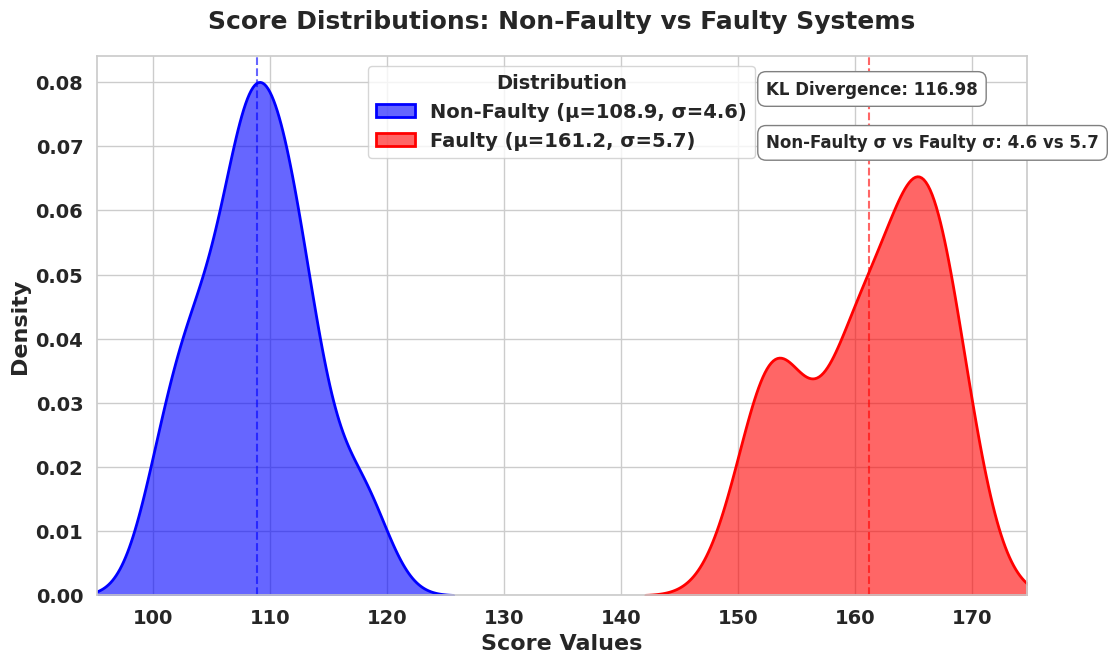

Non-Faulty stats: μ = 108.87, σ = 4.62
Faulty stats: μ = 161.18, σ = 5.75
KL Divergence: 116.9802


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.integrate import quad

# Define your data
non_faulty = np.array([112.48, 109.31, 113.24, 117.62, 108.83, 108.83, 117.90, 113.84, 107.65,
                       112.71, 107.68, 107.67, 111.21, 100.43, 101.38, 107.19, 104.94, 111.57,
                       105.46, 102.94, 117.33, 108.87, 110.34, 102.88, 107.28, 110.55, 104.25,
                       111.88, 106.99, 108.54, 106.99, 119.26, 109.93, 104.71, 114.11, 103.90,
                       111.04, 100.20, 103.36, 110.98, 113.69, 110.86, 109.42, 108.49, 102.61,
                       106.40, 107.70, 115.29, 111.72, 101.18])

faulty = np.array([153.24, 166.15, 163.23, 166.12, 160.31, 159.31, 161.61, 166.91, 153.31,
                   159.76, 165.21, 168.14, 168.94, 168.04, 158.13, 163.56, 169.28, 160.04,
                   153.62, 163.55, 153.61, 165.38, 169.64, 165.65, 153.80, 158.22, 150.87,
                   167.01, 160.92, 160.12, 167.80, 153.57, 164.78, 164.82, 161.92, 164.98,
                   159.15, 153.29, 164.70, 155.13, 150.97, 159.69, 162.98, 166.72, 166.08,
                   165.36, 152.96, 152.61, 150.05, 167.65])

# Calculate statistics
nf_mean, nf_std = np.mean(non_faulty), np.std(non_faulty)
f_mean, f_std = np.mean(faulty), np.std(faulty)

# Calculate KL divergence
def kl_divergence(p, q, x):
    return p(x) * np.log(p(x) / q(x))

def calculate_kl_divergence(array1, array2):
    kde1 = gaussian_kde(array1)
    kde2 = gaussian_kde(array2)

    # Define the range of integration
    x_min = min(array1.min(), array2.min())
    x_max = max(array1.max(), array2.max())

    # Calculate KL divergence
    integral, _ = quad(lambda x: kl_divergence(kde1, kde2, x), x_min, x_max)

    return integral

kl_div = calculate_kl_divergence(non_faulty, faulty)

# Generate KDE plots with enhanced visualization
plt.figure(figsize=(12, 7))
sns.set(style="whitegrid", palette="pastel")

# Set font sizes
title_fontsize = 18
label_fontsize = 16
legend_fontsize = 14
annotation_fontsize = 12
tick_fontsize = 14

# Plot distributions
ax = sns.kdeplot(non_faulty, label=f'Non-Faulty (μ={nf_mean:.1f}, σ={nf_std:.1f})',
                 shade=True, color='blue', alpha=0.6, linewidth=2)
sns.kdeplot(faulty, label=f'Faulty (μ={f_mean:.1f}, σ={f_std:.1f})',
            shade=True, color='red', alpha=0.6, linewidth=2)

# Add vertical lines for means
plt.axvline(nf_mean, color='blue', linestyle='--', alpha=0.6)
plt.axvline(f_mean, color='red', linestyle='--', alpha=0.6)

# Add annotations with bold text
plt.annotate(f'KL Divergence: {kl_div:.2f}',
             xy=(0.72, 0.93), xycoords='axes fraction',
             bbox=dict(boxstyle='round', fc='white', ec='gray', pad=0.5),
             fontsize=annotation_fontsize, fontweight='bold')

plt.annotate(f'Non-Faulty σ vs Faulty σ: {nf_std:.1f} vs {f_std:.1f}',
             xy=(0.72, 0.83), xycoords='axes fraction',
             bbox=dict(boxstyle='round', fc='white', ec='gray', pad=0.5),
             fontsize=annotation_fontsize, fontweight='bold')

# Customize plot with bold labels
plt.title('Score Distributions: Non-Faulty vs Faulty Systems',
          fontsize=title_fontsize, pad=20, fontweight='bold')
plt.xlabel('Score Values', fontsize=label_fontsize, fontweight='bold')
plt.ylabel('Density', fontsize=label_fontsize, fontweight='bold')

# Customize legend
legend = plt.legend(title='Distribution', title_fontsize=legend_fontsize,
                   fontsize=legend_fontsize, loc='upper center')
legend.get_title().set_fontweight('bold')
for text in legend.get_texts():
    text.set_fontweight('bold')

# Set x-axis ticks explicitly to ensure all are bold
x_ticks = [100, 110, 120, 130, 140, 150, 160, 170]
plt.xticks(x_ticks, fontsize=tick_fontsize, fontweight='bold')
plt.yticks(fontsize=tick_fontsize, fontweight='bold')

# Additional explicit formatting to catch all ticks
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(tick_fontsize)

# Set x-axis limits to show full distributions
plt.xlim(min(non_faulty.min(), faulty.min()) - 5,
         max(non_faulty.max(), faulty.max()) + 5)

# Save high-quality plot
plt.savefig('faulty_vs_nonfaulty_kde_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Non-Faulty stats: μ = {nf_mean:.2f}, σ = {nf_std:.2f}")
print(f"Faulty stats: μ = {f_mean:.2f}, σ = {f_std:.2f}")
print(f"KL Divergence: {kl_div:.4f}")